#  Классификация SVM


#### Описание набора данных:  

age     -  возраст: разница в 5 лет  
height(cm)   -      рост(см)  
weight(kg)  -   вес(кг)  
waist(cm)   -   талия(см) окружность талии длина  
eyesight(left)  -   зрение(слева)  
eyesight(right) -   зрение(справа)  
hearing(left)   -   слух(слева)  
hearing(right)  -   слух(справа)  
systolic    -   систолическое: артериальное давление  
relaxation  -   расслабление: артериальное давление 
fasting blood sugar -   уровень сахара в крови натощак  
Cholesterol     -   холестерин: общие  
triglyceride    -   триглицериды  
HDL     -   ЛПВП: тип холестерина  
LDL     -   ЛПНП: тип холестерина  
hemoglobin  -   гемоглобин  
Urine protein   -   белок  мочи  
serum creatinine    -   сывороточный креатинин  
AST -   АСТ: тип глутаминовой щавелевоуксусной трансаминазы  
ALT -   АЛТ: тип глутаминовой щавелевоуксусной трансаминазы  
Gtp -   ГТП: γ-ГТФ  
dental caries   -   кариес зубов  
smoking -   курение  


In [1]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


from cuml.metrics._ranking import roc_auc_score as cuml_roc_auc_score
from cuml.metrics._ranking import precision_recall_curve
from cuml.metrics.accuracy import accuracy_score  as cuml_accuracy_score
from cuml.metrics.confusion_matrix import confusion_matrix as cuml_confusion_matrix



from sklearn.svm import LinearSVC  # Используем LinearSVC для линейного ядра
from cuml.svm import SVC as cuSVC  # Используем GPU-ускоренную модель SVC
import cudf
import cupy as cp



In [2]:
print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)
print("\nДатасет: ")
!ls dataset

Виртуальное окружение
/home/maksim/anaconda3/envs/myenv/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/4_SVM

Датасет: 
ls: невозможно получить доступ к 'dataset': Нет такого файла или каталога


## Функции 

## 1) Загрузка

In [3]:

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))

X = train_df.drop(columns=['smoking'])
y = train_df['smoking']
print("\nПропуски:")
train_df.isnull().sum()



Размер данных:  (38984, 23)
 age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  smoking
  35         170          85       97.0             0.9              0.9              1               1       118          78                   97          239           153   70  142        19.8              1               1.0   61  115  125              1        1
  20         175         110      110.0             0.7              0.9              1               1       119          79                   88          211           128   71  114        15.9              1               1.1   19   25   30              1        0
  45         155          65       86.0             0.9              0.9              1               1       110          80                   80          193        

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

## 2) Анализ

In [4]:
# 2) EDA: исследование данных
def explore_data(df):
    eda_results = pd.DataFrame({
        'Missing (%)': df.isnull().mean() * 100,
        'Min': df.min(),
        'Max': df.max(),
        'Mean': df.mean(),
        'Median': df.median(),
        'Variance': df.var(),
        'Quantile 0.1': df.quantile(0.1),
        'Quantile 0.9': df.quantile(0.9),
        'Quartile 1': df.quantile(0.25),
        'Quartile 3': df.quantile(0.75),
    })
    return eda_results

In [5]:
print("EDA Анализ\n")
explore_data(train_df)

EDA Анализ



,Missing (%),Min,Max,Mean,Median,Variance,Quantile 0.1,Quantile 0.9,Quartile 1,Quartile 3
age,0.0,20.0,85.0,44.127591,40.0,145.529573,30.0,60.0,40.0,55.0
height(cm),0.0,130.0,190.0,164.689488,165.0,84.410288,150.0,175.0,160.0,170.0
weight(kg),0.0,30.0,135.0,65.938718,65.0,166.321797,50.0,85.0,55.0,75.0
waist(cm),0.0,51.0,129.0,82.062115,82.0,86.989160,70.0,94.0,76.0,88.0
eyesight(left),0.0,0.1,9.9,1.014955,1.0,0.248529,0.6,1.5,0.8,1.2
eyesight(right),0.0,0.1,9.9,1.008768,1.0,0.243851,0.6,1.5,0.8,1.2
hearing(left),0.0,1.0,2.0,1.025369,1.0,0.024726,1.0,1.0,1.0,1.0
hearing(right),0.0,1.0,2.0,1.026190,1.0,0.025505,1.0,1.0,1.0,1.0
systolic,0.0,71.0,233.0,121.475631,120.0,186.145675,104.0,138.0,112.0,130.0
relaxation,0.0,40.0,146.0,75.994408,76.0,93.291147,64.0,88.0,70.0,82.0


## 3) Доля курящих

In [6]:
# Доля 1 в целевой переменной
target_ratio = train_df['smoking'].mean()
print(f'Доля курящих (smoking=1): {target_ratio:.2%}')

Доля курящих (smoking=1): 36.73%


## 4) Графики

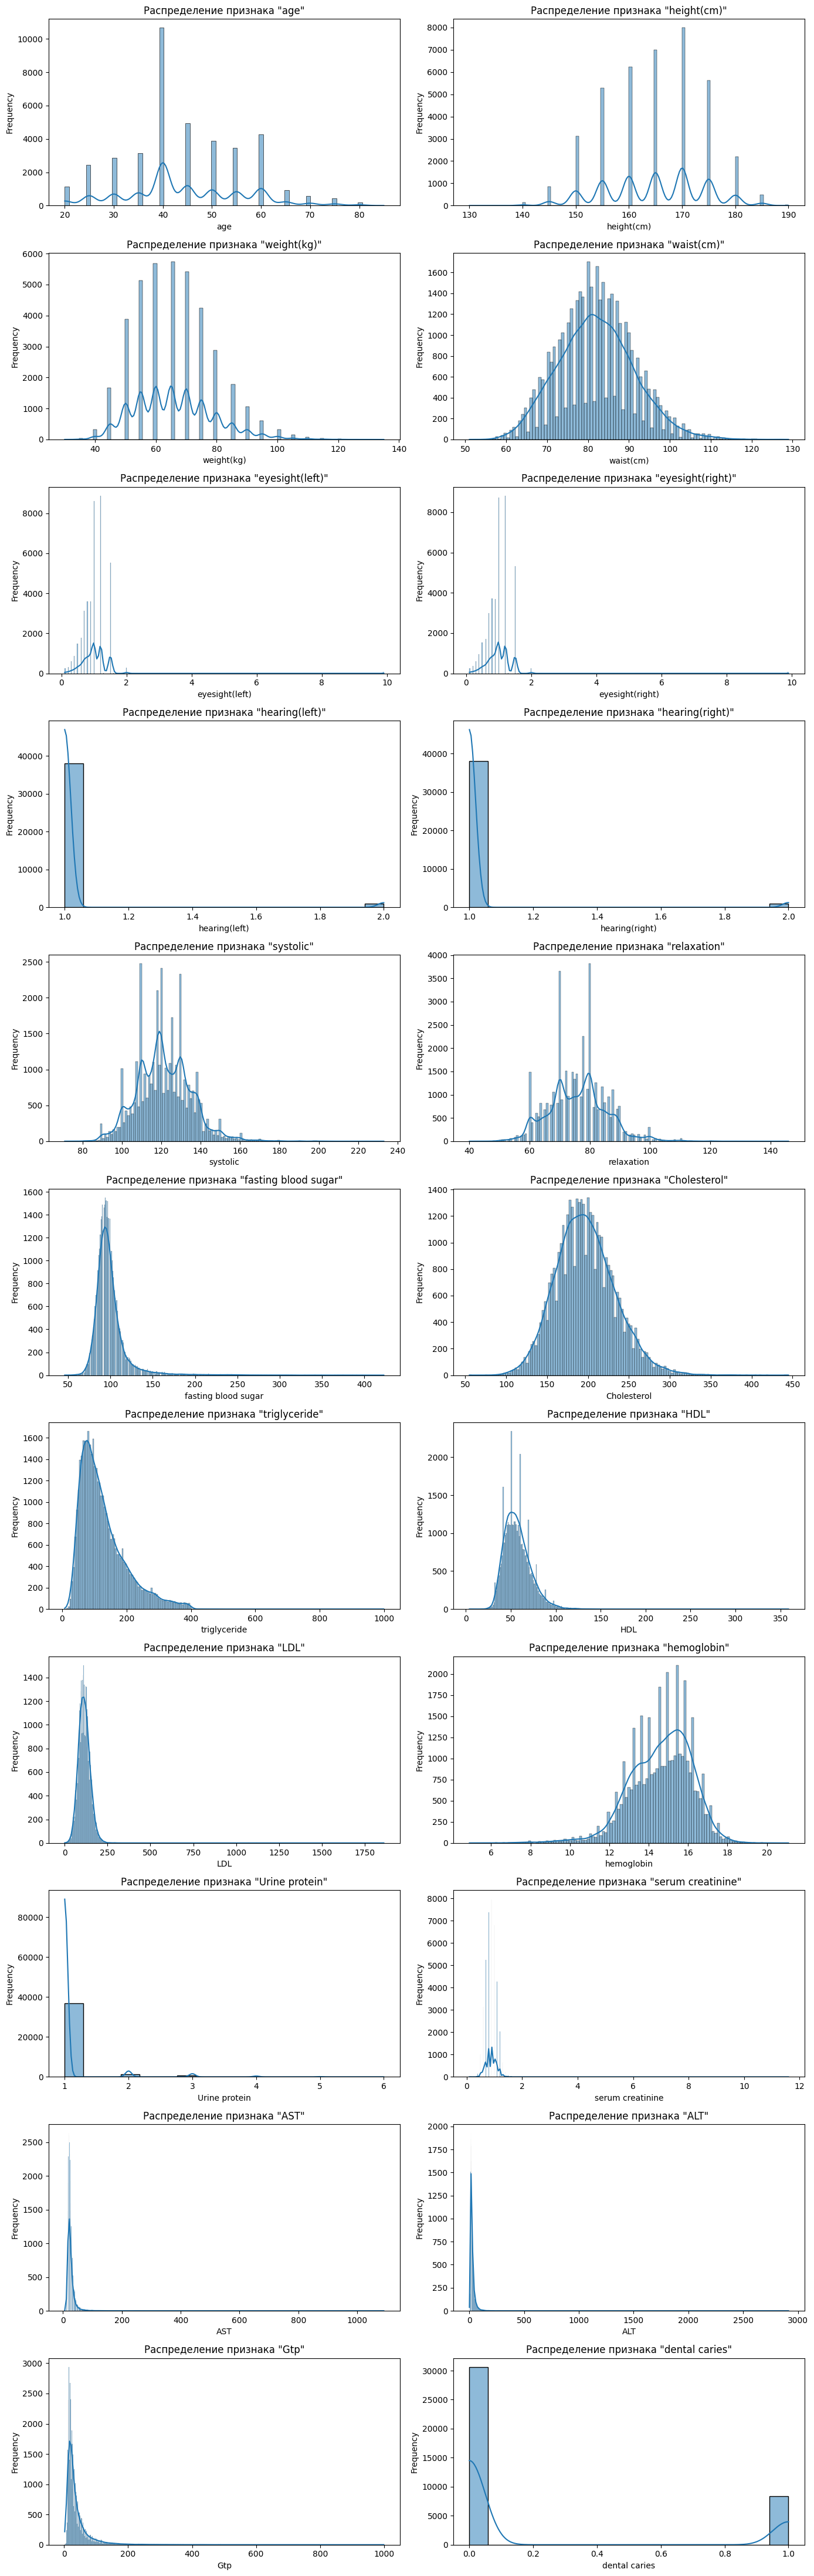

In [7]:

# Получаем список всех признаков (кроме целевой переменной)
features = X.columns

num_features = len(features)
num_rows = (num_features + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
axes = axes.flatten() 

for i, feature in enumerate(features):
    sns.histplot(X[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение признака "{feature}"')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


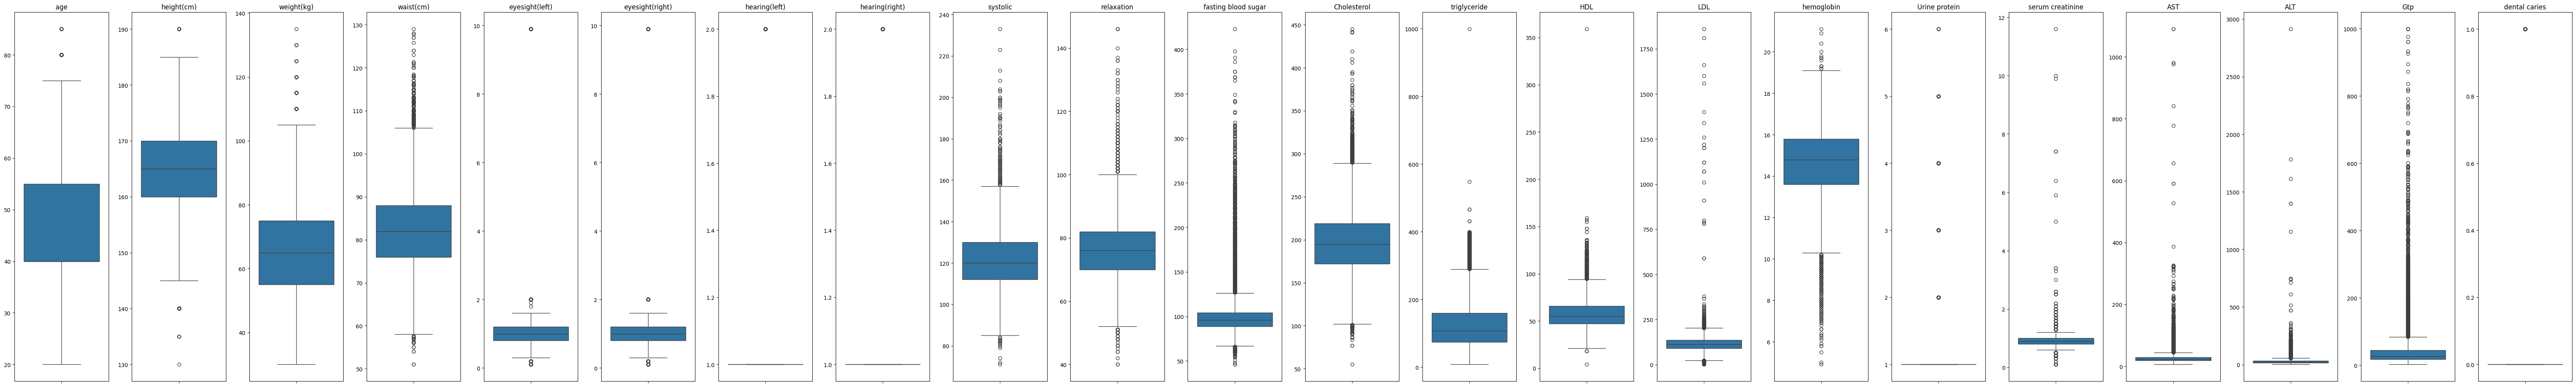

In [8]:

features = X.columns

num_features = len(features)

fig, axes = plt.subplots(1, num_features, figsize=(num_features * 3, 10))

for i, feature in enumerate(features):
    sns.boxplot(y=X[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()


## 5) Обучение

### Проверка GPU

In [9]:
!which nvcc


/usr/local/cuda-12.8/bin/nvcc


In [10]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:20:09_PST_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0


In [11]:
import os
print(os.environ.get("CUDA_HOME"))


/usr/local/cuda-12.8


In [12]:
import cuml
print(cuml.__version__)


25.02.00


### Обучение

In [13]:
X = train_df.drop(columns=['smoking'])
y = train_df['smoking']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



X_train_scaled_gpu = cp.asarray(X_train_scaled)  
X_val_scaled_gpu = cp.asarray(X_val_scaled)  


y_train_gpu = cp.asarray(y_train)
y_val_gpu = cp.asarray(y_val)



Метрики качества модели SVM (GPU-ускоренной):
Accuracy: 0.7498
Precision: 0.6794
Recall: 0.6037
F1-score: 0.6393
ROC AUC: 0.8282


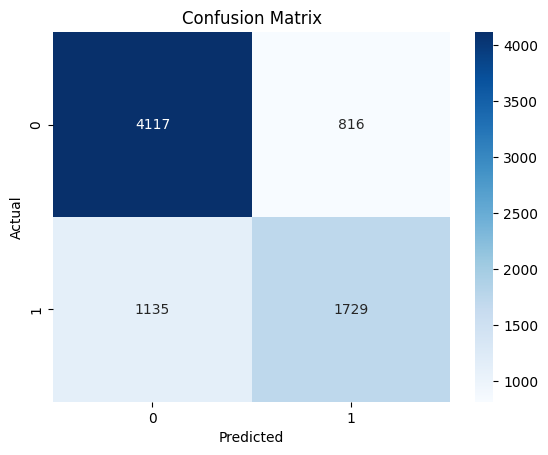

In [14]:

best_model = cuSVC(C=1, kernel='rbf', probability=True, cache_size=4000)


best_model.fit(X_train_scaled_gpu, y_train_gpu)


y_pred = best_model.predict(X_val_scaled_gpu)
y_pred_proba = best_model.decision_function(X_val_scaled_gpu)  # Для "rbf" ядра используем decision_function



accuracy = cuml_accuracy_score(y_val_gpu, y_pred)
prc = precision_recall_curve(y_val_gpu, y_pred)
precision = prc[0][1].item()
recall = prc[1][1].item()
f1 = f1_score(y_val_gpu.get(), y_pred.get())
roc_auc = cuml_roc_auc_score(y_val_gpu, y_pred_proba)


# Вывод метрик качества
print("\nМетрики качества модели SVM (GPU-ускоренной):")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')



# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_val_gpu.get(), y_pred.get())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Подбор гиперпараметров модели


 **Результаты обучения моделей:**
      C  Kernel  Accuracy    Time (s)
0   0.1  linear  0.717455    0.067430
1   1.0  linear  0.717455    0.064108
2  10.0  linear  0.717455    0.060812
3   0.1     rbf  0.735796    3.154032
4   1.0     rbf  0.749776    4.722520
5  10.0     rbf  0.757727   25.554643
6   0.1    poly  0.701808    7.801503
7   1.0    poly  0.709247   21.008715
8  10.0    poly  0.700269  195.184844

Общее время подбора гиперпараметров: 261.5470 секунд

 **Лучшая модель:** {'C': 10, 'kernel': 'rbf'}
**Метрики лучшей модели:**
Accuracy: 0.7577
Precision: 0.6923
Recall: 0.6128
F1-score: 0.6501
ROC AUC: 0.8308


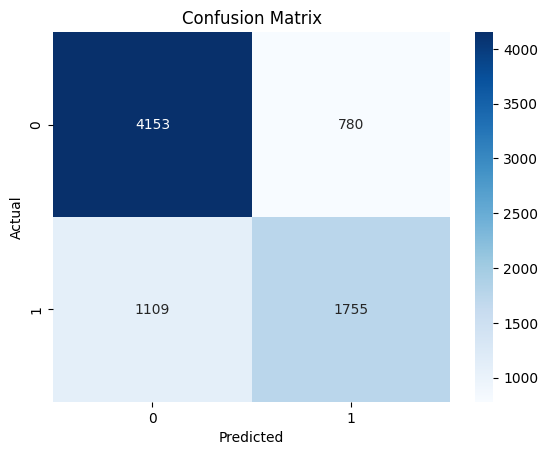

In [15]:

# Гиперпараметры для подбора
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
results = []  
best_accuracy = 0
best_model = None
best_params = None

start_time_total = time.time()  # Засекаем общее время

for kernel in param_grid['kernel']:
    for C in param_grid['C']:
        start_time = time.time()  # Засекаем время для текущей модели

        # Создаём модель
        if kernel == 'linear':
            model = LinearSVC(C=C, max_iter=10000)
            # Для LinearSVC работаем с данными на CPU
            X_train_fit = X_train_scaled  # Оставляем данные на CPU
            y_train_fit = y_train
            y_val_fit = y_val
            X_val_scaled_fit = X_val_scaled
        else:
            model = cuSVC(C=C, kernel=kernel, probability=True, cache_size=4000)
            # Для cuSVC оставляем данные на GPU
            X_train_fit = X_train_scaled_gpu  # Оставляем данные на GPU
            y_train_fit = y_train_gpu
            y_val_fit = y_val
            X_val_scaled_fit = X_val_scaled_gpu

        # Обучаем модель
        model.fit(X_train_fit, y_train_fit)
        training_time = time.time() - start_time  # Время обучения модели

        # Делаем предсказания
        if kernel == 'linear':
            y_pred = model.predict(X_val_scaled)  # Для LinearSVC работаем с CPU-данными
            # y_pred_proba = model.decision_function(X_val_scaled)  # Для LinearSVC используем decision_function
            accuracy = accuracy_score(y_val, y_pred)
        else:
            y_pred = model.predict(X_val_scaled_gpu)  # Для cuSVC работаем с GPU-данными
            # y_pred_proba = model.predict_proba(X_val_scaled_gpu)[:, 1]  # Для cuSVC получаем вероятности
            # Оценка точности модели
            accuracy = cuml_accuracy_score(y_val, y_pred)

        # print(f"Accuracy for C={C}, Kernel={kernel}: {accuracy:.4f}")

        # Сохраняем результаты
        results.append({'C': C, 'Kernel': kernel, 'Accuracy': accuracy, 'Time (s)': training_time})

        # Обновляем лучшую модель
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_params = {'C': C, 'kernel': kernel}

# Общее время подбора гиперпараметров
training_time_total = time.time() - start_time_total

# Выводим результаты
df_results = pd.DataFrame(results)
print("\n **Результаты обучения моделей:**")
print(df_results)

print(f"\nОбщее время подбора гиперпараметров: {training_time_total:.4f} секунд")

# Оценка лучшей модели
if best_params['kernel'] == 'linear':
    y_pred = best_model.predict(X_val_scaled)
    y_pred_proba = best_model.decision_function(X_val_scaled)
    
    
else:
    y_pred = best_model.predict(X_val_scaled_gpu)
    y_pred_proba = best_model.predict_proba(X_val_scaled_gpu)[:, 1]
    y_pred = y_pred.get()
    y_pred_proba = y_pred_proba.get()


# Вычисление метрик
conf_matrix = confusion_matrix(y_val_fit, y_pred)
accuracy = accuracy_score(y_val_fit, y_pred)
precision = precision_score(y_val_fit, y_pred)
recall = recall_score(y_val_fit, y_pred)
f1 = f1_score(y_val_fit, y_pred)
roc_auc = roc_auc_score(y_val_fit, y_pred_proba)

print("\n **Лучшая модель:**", best_params)
print("**Метрики лучшей модели:**")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Визуализация матрицы ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Выбор степени полинома


 **Результаты обучения моделей (полиномиальное ядро):**
       C  Degree  Accuracy    Time (s)
5    1.0       3  0.709247   20.808406
1    0.1       3  0.701808    7.740841
9   10.0       3  0.700269  194.605783
8   10.0       2  0.668206  138.089258
4    1.0       2  0.666025   21.279815
2    0.1       4  0.665769   12.832312
0    0.1       2  0.661023    8.323174
3    0.1       5  0.650122   14.715942
6    1.0       4  0.644735   35.390025
7    1.0       5  0.637040   37.985708
10  10.0       4  0.635116  208.673203
11  10.0       5  0.633064  203.761238

Общее время подбора гиперпараметров: 926.6343 секунд

 **Лучшая модель:** {'C': 1, 'degree': 3}
**Метрики лучшей модели:**
Accuracy: 0.7092
Precision: 0.7026
Recall: 0.3614
F1-score: 0.4773
ROC AUC: 0.7997


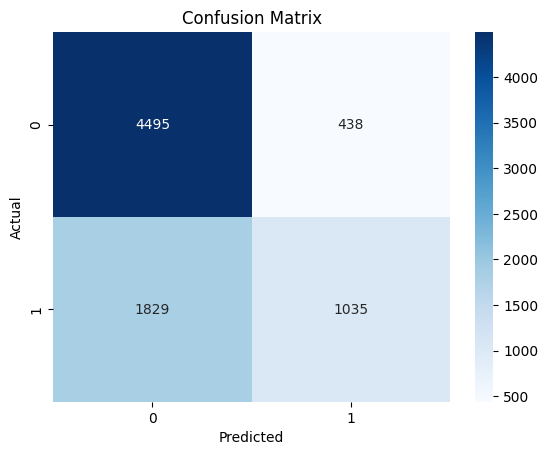

In [16]:

param_grid = {
    'C': [0.1, 1, 10], 
    'degree': [2, 3, 4, 5] 
}

results = [] 
best_accuracy = 0
best_model = None
best_params = None

start_time_total = time.time()  

for C in param_grid['C']:
    for degree in param_grid['degree']:
        start_time = time.time()  

       
        model = cuSVC(C=C, kernel='poly', degree=degree, probability=True, cache_size=4000)

        model.fit(X_train_scaled, y_train)
        training_time = time.time() - start_time  

        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.decision_function(X_val_scaled)

        accuracy = cuml_accuracy_score(y_val, y_pred)

        results.append({'C': C, 'Degree': degree, 'Accuracy': accuracy, 'Time (s)': training_time})

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_params = {'C': C, 'degree': degree}

training_time_total = time.time() - start_time_total


df_results = pd.DataFrame(results)
print("\n **Результаты обучения моделей (полиномиальное ядро):**")
print(df_results.sort_values(by="Accuracy", ascending=False))  

print(f"\nОбщее время подбора гиперпараметров: {training_time_total:.4f} секунд")

y_pred = best_model.predict(X_val_scaled)
y_pred_proba = best_model.decision_function(X_val_scaled)

conf_matrix = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print("\n **Лучшая модель:**", best_params)
print("**Метрики лучшей модели:**")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


##### Полином работает хуже чем __rbf__, лучший результат полинома с третьей степенью!

### Выводы

__Лучшие параметры модели__:  

{'C': 10, 'kernel': 'rbf'} 

__Метрики лучшей модели__: 

Accuracy: 0.7577  
Precision: 0.6923  
Recall: 0.6128  
F1-score: 0.6501  
ROC AUC: 0.8304  
